# Welcome to the Healthcare Hackathon

This weekend you will be working on solving critical healthcare problems using your Data Science skills. This notebook will help you get up and running quickly with the data. But before we get to the data, first we need to configure a username and email.

In [12]:
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [13]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]

sns.set_style('whitegrid')


In [3]:
!git config --global user.name Florian
!git config --global user.email florian.perdreau@gmail.com

Next we need to setup a git branch. This is the branch you will use during the hackathon.

In [4]:
# Fill in the name of your team as the branch name
!git checkout -b mosquitopie_prod
!git push --set-upstream origin $(git rev-parse --abbrev-ref HEAD)

fatal: A branch named 'mosquitopie_prod' already exists.
Branch mosquitopie-prod set up to track remote branch mosquitopie-prod from origin.
Everything up-to-date


Now you have a branch to work with. If you want to create commits and push your code you can execute the following snippet: `!git commit -a -m "Add a descriptive message here for your commits"`

# Getting Started with the data

Several data sets are available this weekend. Each data set can be downloaded from s3. For each subject in the hackathon we created a seperate folder. The following folders are available: CarePay, MCF, MomCare, NWH, RedCross, SafeCare, SatelliteImages. You can use the following code snippet to list the data in the s3 bucket and download the data:

In [14]:
import boto3
import pandas as pd
from sagemaker import get_execution_role

def list_data(folder):
    """
    List all available data sets in the folder
    """
    s3 = boto3.resource('s3')
    bucket='cp-hackathon-data'
    hackathon_data = s3.Bucket(bucket)
    keys = []
    for obj in hackathon_data.objects.filter(Prefix=folder):
        keys.append(obj.key)
    return keys


def get_data(key):
    role = get_execution_role()
    bucket='cp-hackathon-data'
    data_location = 's3://{}/{}'.format(bucket, key)
    return pd.read_csv(data_location)

In [6]:
list_data('RedCross')

['RedCross/',
 'RedCross/ovitrap_data.csv',
 'RedCross/ovitrap_data_monthly_province.csv',
 'RedCross/weather_data_monthly_province.csv']

# EDA

In [7]:
aggregated_data = get_data('RedCross/ovitrap_data_monthly_province.csv')
aggregated_data['date'] = pd.to_datetime(aggregated_data['date'])
aggregated_data['month'] = aggregated_data['date'].map(lambda date: date.month)
aggregated_data['year'] = aggregated_data['date'].map(lambda date: date.year)
aggregated_data.head()

Couldn't call 'get_role' to get Role ARN from role name cp-sagemaker-hackathon-role to get Role path.


,adm_level,date,count_ovi,mean_ovi,error_ovi,error_relative_ovi,month,year
0,Negros Occidental,2012-01-01,2.0,27.5,17.324116,0.629968,1,2012
1,Negros Occidental,2012-02-01,0.0,NaN,NaN,NaN,2,2012
2,Negros Occidental,2012-03-01,0.0,NaN,NaN,NaN,3,2012
3,Negros Occidental,2012-04-01,0.0,NaN,NaN,NaN,4,2012
4,Negros Occidental,2012-05-01,0.0,NaN,NaN,NaN,5,2012


In [8]:
print(f'Number of administration levels: {aggregated_data.adm_level.nunique()}')

Number of administration levels: 86


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


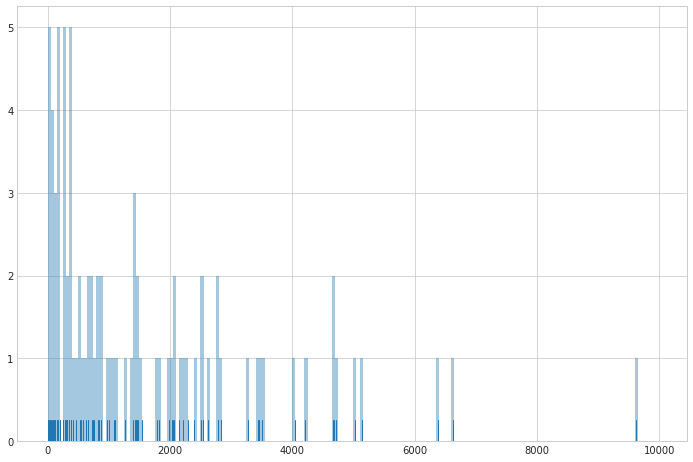

In [158]:
# Check total number of mosquitos per administration level
total_count_per_adm = (aggregated_data
                .groupby('adm_level')
                .apply(lambda group: (group['count_ovi']).sum())
                )

# Distribution of # of counted mosquitos per region
sns.distplot(total_count_per_adm, kde=False, rug=True, bins=np.arange(0, 10000, 50))

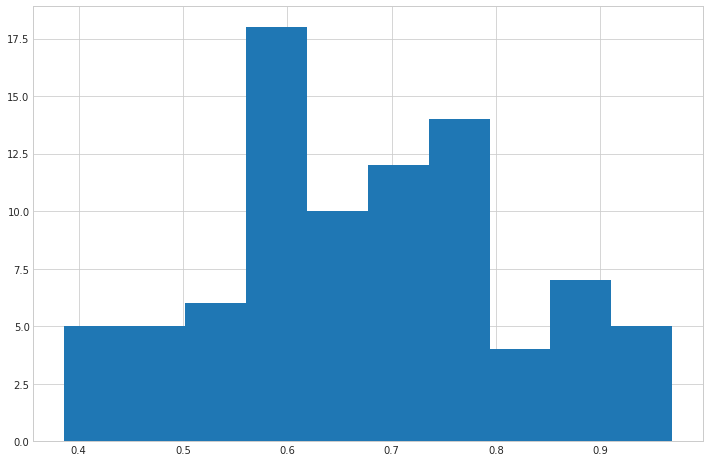

In [159]:
# Check proportion of missing values per administration level
count_per_adm = (aggregated_data
                .groupby('adm_level')
                .apply(lambda group: (group['count_ovi'] == 0).mean())
                )
count_per_adm.hist()

In [157]:
count_per_adm_time = (aggregated_data
                     .groupby(['adm_level', 'date'])
                     .agg({'error_ovi': np.mean, 'mean_ovi': np.mean, 'count_ovi': np.mean})
                     .reset_index()
                     )
count_per_adm_time['indicator_mean'] = (count_per_adm_time
                                   .apply(lambda row: row['mean_ovi'] if row['count_ovi'] > 0 else -1,
                                         axis=1)
                                  )
count_per_adm_time['indicator_error'] = (count_per_adm_time
                                   .apply(lambda row: row['error_ovi'] if row['count_ovi'] > 0 else -1,
                                         axis=1)
                                  )
count_per_adm_time.head()

,adm_level,date,error_ovi,mean_ovi,count_ovi,indicator_mean,indicator_error
0,Abra,2012-01-01,NaN,NaN,0.0,-1.0,-1.0
1,Abra,2012-02-01,NaN,NaN,0.0,-1.0,-1.0
2,Abra,2012-03-01,NaN,NaN,0.0,-1.0,-1.0
3,Abra,2012-04-01,NaN,NaN,0.0,-1.0,-1.0
4,Abra,2012-05-01,NaN,NaN,0.0,-1.0,-1.0


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


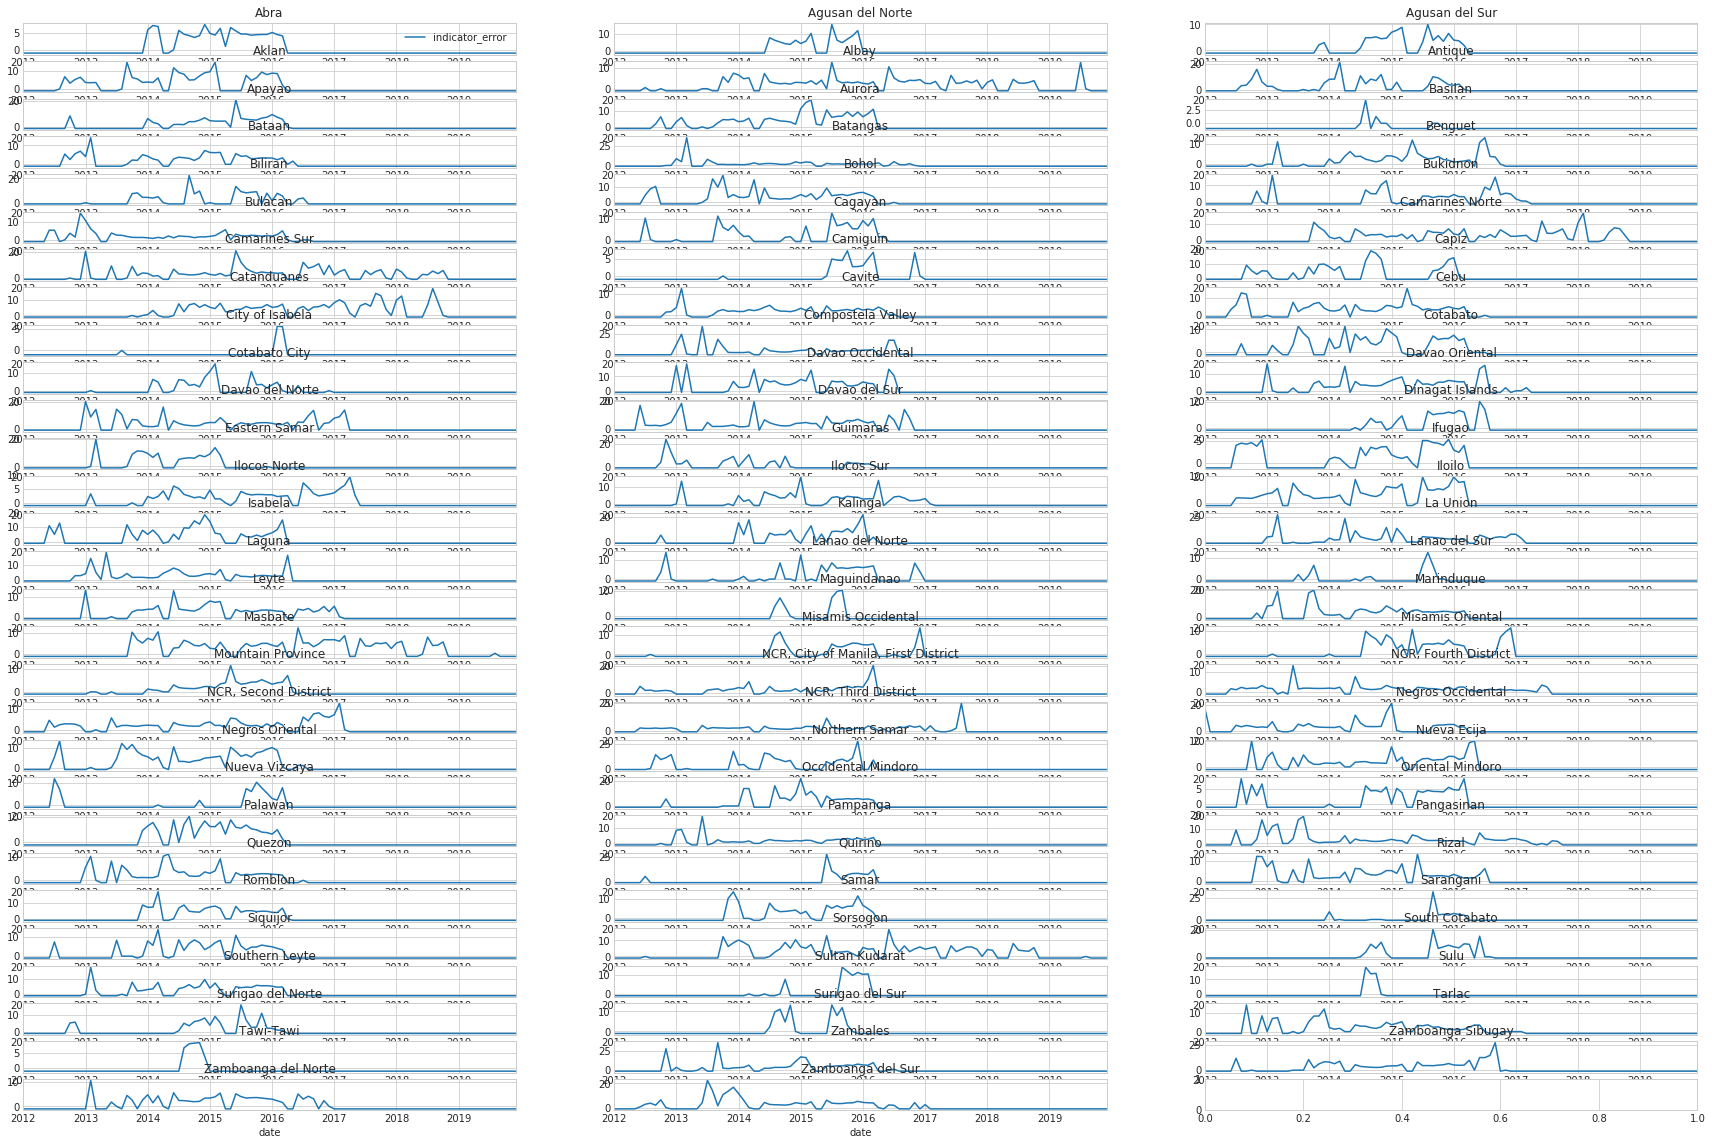

In [160]:
levels = count_per_adm_time.adm_level.unique()

ncols = 3
nrows = int(np.ceil(len(levels)/ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(30, 20))
axes = axes.flatten()

for count, level in enumerate(levels):
    data_plot = count_per_adm_time.loc[count_per_adm_time.adm_level == level]
    data_plot.plot(x='date', 
                   y='indicator_error',
                   ax=axes[count]
                   )
    axes[count].set_title(level)
    if count > 0:
        axes[count].get_legend().remove()
    
plt.tight_layout()

In [ ]:

count_per_adm_year = (aggregated_data
                     .loc[aggregated_data.count_ovi > 0]
                     .groupby(['adm_level', 'year'])
                     .agg({'mean_ovi': np.sum, 'count_ovi': np.sum})
                     .reset_index()
                     )
count_per_adm_year['per_count'] = count_per_adm_year['mean_ovi'] / count_per_adm_year['count_ovi']

count_per_adm_year.head(10)

In [ ]:

count_per_adm_month = (aggregated_data
                     .loc[aggregated_data.count_ovi > 0]
                     .groupby(['adm_level', 'month'])
                     .agg({'mean_ovi': np.sum, 'count_ovi': np.sum})
                     .reset_index()
                     )
count_per_adm_month['per_count'] = count_per_adm_year['mean_ovi'] / count_per_adm_year['count_ovi']

count_per_adm_month.head(10)

In [ ]:

ncols = 3
nrows = int(np.ceil(len(levels)/ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(30, 20))
axes = axes.flatten()

for count, level in enumerate(levels):
    data_plot = count_per_adm_month.loc[count_per_adm_month.adm_level == level]
    data_plot.plot(x='month', 
                   y='mean_ovi',
                   ax=axes[count]
                   )
    axes[count].set_title(level)
    if count > 0:
        axes[count].get_legend().remove()
    
plt.tight_layout()

With the `get_data` function you can download the relevant dataset from s3. For the people that like R, you can achieve something similar with the following snippet:

```
library(reticulate)
sagemaker <- import('sagemaker')
session <- sagemaker$Session()
role_arn <- sagemaker$get_execution_role()
folder <- <fill in your folder here>
session$list_s3_files('cp-hackathon-data', folder)
session$read_s3_file('cp-hackathon-data', <some key in the bucket here>)
```

For more information on R, check out [this link to the documentation](https://sagemaker.readthedocs.io/en/stable/session.html#sagemaker.session.Session.read_s3_file)

# Happy Hacking!

In [15]:
aggregated_data = get_data('RedCross/ovitrap_data_monthly_province.csv')
aggregated_data['date'] = pd.to_datetime(aggregated_data['date'])
aggregated_data['month'] = aggregated_data['date'].map(lambda date: date.month)
aggregated_data['year'] = aggregated_data['date'].map(lambda date: date.year)
aggregated_data.head()

Couldn't call 'get_role' to get Role ARN from role name cp-sagemaker-hackathon-role to get Role path.


,adm_level,date,count_ovi,mean_ovi,error_ovi,error_relative_ovi,month,year
0,Negros Occidental,2012-01-01,2.0,27.5,17.324116,0.629968,1,2012
1,Negros Occidental,2012-02-01,0.0,NaN,NaN,NaN,2,2012
2,Negros Occidental,2012-03-01,0.0,NaN,NaN,NaN,3,2012
3,Negros Occidental,2012-04-01,0.0,NaN,NaN,NaN,4,2012
4,Negros Occidental,2012-05-01,0.0,NaN,NaN,NaN,5,2012


In [66]:
raw_ovi_data = get_data('RedCross/ovitrap_data.csv')
raw_ovi_data['date'] = pd.to_datetime(raw_ovi_data['date'])
raw_ovi_data['month'] = raw_ovi_data['date'].map(lambda date: date.month)
raw_ovi_data['year'] = raw_ovi_data['date'].map(lambda date: date.year)
raw_ovi_data['week'] = raw_ovi_data['date'].map(lambda date: date.week)

raw_ovi_data['point_id'] = (raw_ovi_data.groupby(by =['latitude','longitude']).cumcount()==0).astype(int)
raw_ovi_data['point_id'] = raw_ovi_data['point_id'].cumsum()
raw_ovi_data = raw_ovi_data.drop(columns=['Unnamed: 0'])
raw_ovi_data.head()

Couldn't call 'get_role' to get Role ARN from role name cp-sagemaker-hackathon-role to get Role path.


,date,id,latitude,longitude,name,value,month,year,week,point_id
0,2012-06-19,3,14.5044,121.056,Kapitan Jose Cardones Memorial School,17.31,6,2012,25,1
1,2012-07-03,3,14.5044,121.056,Kapitan Jose Cardones Memorial School,15.52,7,2012,27,1
2,2012-07-17,3,14.5044,121.056,Kapitan Jose Cardones Memorial School,30.00,7,2012,29,1
3,2012-07-24,3,14.5044,121.056,Kapitan Jose Cardones Memorial School,22.64,7,2012,30,1
4,2012-09-11,3,14.5044,121.056,Kapitan Jose Cardones Memorial School,28.13,9,2012,37,1


In [112]:
import psycopg2

connection = psycopg2.connect(user = "health_hackathon",
                              password = "Health_100%",
                              host = "mosquitopie.cluster-crqnajfhzbab.eu-west-1.rds.amazonaws.com",
                              port = "5432",
                              database = "mosquito-spatial")
    
schools_adm_gps = pd.read_sql("SELECT * FROM analysis.schools_adm_boundaries;", connection)
schools_adm_gps.head()

,point_id,latitude,longitude,adm2_en
0,7546.0,17.819566,120.802585,Abra
1,7606.0,17.619125,120.685780,Abra
2,7658.0,17.563315,120.989276,Abra
3,7669.0,17.733497,120.708136,Abra
4,7673.0,17.646691,120.710841,Abra


In [113]:

# Get schools buffer
population_elevation_schools = pd.read_sql("SELECT * FROM analysis.population_elevation_schools;", connection)
population_elevation_schools.head()

,tid,geom,point_id,pop_mean,pop_median,pop_min,pop_max,elev_mean,elev_median,elev_min,elev_max
0,1,0103000020E61000000100000069010000D7195F6ABC4A...,353.0,NaN,NaN,NaN,NaN,636.666667,641.0,543.0,726.0
1,2,0103000020E6100000010000006901000042ECEC84A882...,459.0,NaN,NaN,NaN,NaN,471.333333,436.0,378.0,600.0
2,3,0103000020E610000001000000690100007D2A8F4EA882...,488.0,NaN,NaN,NaN,NaN,471.333333,436.0,378.0,600.0
3,4,0103000020E61000000100000069010000A0F29C191ABF...,506.0,NaN,NaN,NaN,NaN,18.666667,19.0,18.0,19.0
4,5,0103000020E6100000010000006901000017D552D16349...,820.0,NaN,NaN,NaN,NaN,1845.000000,1864.0,1728.0,1924.0


In [98]:
# Assign administration level to schools based on latitude and longitude
raw_ovi_data_with_admin_level = raw_ovi_data.merge(schools_adm_gps, on=['point_id'], how='left')
raw_ovi_data_with_admin_level.info()
raw_ovi_data_with_admin_level.loc[pd.isna(raw_ovi_data_with_admin_level.adm2_en)].head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 137732 entries, 0 to 137731
Data columns (total 13 columns):
date           137732 non-null datetime64[ns]
id             137732 non-null int64
latitude_x     137732 non-null float64
longitude_x    137732 non-null float64
name           137732 non-null object
value          137732 non-null float64
month          137732 non-null int64
year           137732 non-null int64
week           137732 non-null int64
point_id       137732 non-null int64
latitude_y     137058 non-null float64
longitude_y    137058 non-null float64
adm2_en        137058 non-null object
dtypes: datetime64[ns](1), float64(5), int64(5), object(2)
memory usage: 14.7+ MB


,date,id,latitude_x,longitude_x,name,value,month,year,week,point_id,latitude_y,longitude_y,adm2_en
12206,2012-07-17,1448,9.22982,123.562670,Banban Elementary School,12.50,7,2012,29,458,NaN,NaN,NaN
16092,2012-11-13,2619,14.32959,121.115758,Sinalhan Elementary School,9.09,11,2012,46,760,NaN,NaN,NaN
16093,2012-11-27,2619,14.32959,121.115758,Sinalhan Elementary School,4.55,11,2012,48,760,NaN,NaN,NaN
16094,2012-12-04,2619,14.32959,121.115758,Sinalhan Elementary School,18.18,12,2012,49,760,NaN,NaN,NaN
16095,2012-12-11,2619,14.32959,121.115758,Sinalhan Elementary School,19.70,12,2012,50,760,NaN,NaN,NaN


In [99]:
# Get population density, elevation, etc. for each school
raw_ovi_data_population = raw_ovi_data_with_admin_level.merge(population_elevation_schools, 
                                                              on=['point_id'], 
                                                              how='left')
raw_ovi_data_population.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 137732 entries, 0 to 137731
Data columns (total 23 columns):
date           137732 non-null datetime64[ns]
id             137732 non-null int64
latitude_x     137732 non-null float64
longitude_x    137732 non-null float64
name           137732 non-null object
value          137732 non-null float64
month          137732 non-null int64
year           137732 non-null int64
week           137732 non-null int64
point_id       137732 non-null int64
latitude_y     137058 non-null float64
longitude_y    137058 non-null float64
adm2_en        137058 non-null object
tid            137732 non-null int64
geom           137732 non-null object
pop_mean       134436 non-null float64
pop_median     134436 non-null float64
pop_min        134436 non-null float64
pop_max        134436 non-null float64
elev_mean      137497 non-null float64
elev_median    137497 non-null float64
elev_min       137497 non-null float64
elev_max       137497 non-null float64


In [100]:
raw_ovi_data_population = raw_ovi_data_population.dropna(subset=['adm2_en'])
raw_ovi_data_population = (raw_ovi_data_population
                          .drop(columns=['latitude_y', 'longitude_y', 'point_id'])
                          .rename(columns={'latitude_x': 'latitude', 'longitude_x': 'longitude'})
                          )
raw_ovi_data_population.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 137058 entries, 0 to 137731
Data columns (total 20 columns):
date           137058 non-null datetime64[ns]
id             137058 non-null int64
latitude       137058 non-null float64
longitude      137058 non-null float64
name           137058 non-null object
value          137058 non-null float64
month          137058 non-null int64
year           137058 non-null int64
week           137058 non-null int64
adm2_en        137058 non-null object
tid            137058 non-null int64
geom           137058 non-null object
pop_mean       133944 non-null float64
pop_median     133944 non-null float64
pop_min        133944 non-null float64
pop_max        133944 non-null float64
elev_mean      136946 non-null float64
elev_median    136946 non-null float64
elev_min       136946 non-null float64
elev_max       136946 non-null float64
dtypes: datetime64[ns](1), float64(11), int64(5), object(3)
memory usage: 22.0+ MB


In [101]:
# Get weather data
weather_data = get_data('RedCross/weather_data_monthly_province.csv')
weather_data['date'] = pd.to_datetime(weather_data['date'])
weather_data['month'] = weather_data['date'].map(lambda date: date.month)
weather_data['year'] = weather_data['date'].map(lambda date: date.year)
weather_data['week'] = weather_data['date'].map(lambda date: date.week)
weather_data.head()

Couldn't call 'get_role' to get Role ARN from role name cp-sagemaker-hackathon-role to get Role path.


,adm_level,date,JAXA_GPM_L3_GSMaP_v6_operational_hourlyPrecipRateGC,MODIS_006_MOD11A1_LST_Day_1km,MODIS_006_MOD11A1_LST_Night_1km,MODIS_006_MYD13A1_EVI,NASA_FLDAS_NOAH01_C_GL_M_V001_Qair_f_tavg,NASA_FLDAS_NOAH01_C_GL_M_V001_Rainf_f_tavg,NASA_FLDAS_NOAH01_C_GL_M_V001_SoilMoi00_10cm_tavg,NASA_FLDAS_NOAH01_C_GL_M_V001_SoilTemp00_10cm_tavg,NASA_FLDAS_NOAH01_C_GL_M_V001_Tair_f_tavg,NASA_FLDAS_NOAH01_C_GL_M_V001_Wind_f_tavg,month,year,week
0,Abra,2012-06-01,0.430867,15043.5540,14639.858,4180.8150,0.016763,0.000172,0.425508,296.31796,297.09457,4.977150,6,2012,22
1,Abra,2012-07-01,0.373154,15020.1080,14632.604,3662.6284,0.016362,0.000186,0.428822,295.84708,296.72488,3.478785,7,2012,26
2,Abra,2012-08-01,0.620665,14917.0320,14486.046,3183.5750,0.016541,0.000245,0.432180,295.66570,296.15265,6.328744,8,2012,31
3,Abra,2012-09-01,0.106620,14980.0205,14696.892,4785.5340,0.015967,0.000099,0.419719,296.26144,296.81122,3.009687,9,2012,35
4,Abra,2012-10-01,0.053113,14986.9280,14666.716,4770.0083,0.014127,0.000039,0.390687,295.36737,295.53925,4.924677,10,2012,40


In [102]:
aggregated_weather_data = (weather_data
                          .groupby(['adm_level', 'year', 'month'])
                          .median()
                          .reset_index())
aggregated_weather_data.head()

,adm_level,year,month,JAXA_GPM_L3_GSMaP_v6_operational_hourlyPrecipRateGC,MODIS_006_MOD11A1_LST_Day_1km,MODIS_006_MOD11A1_LST_Night_1km,MODIS_006_MYD13A1_EVI,NASA_FLDAS_NOAH01_C_GL_M_V001_Qair_f_tavg,NASA_FLDAS_NOAH01_C_GL_M_V001_Rainf_f_tavg,NASA_FLDAS_NOAH01_C_GL_M_V001_SoilMoi00_10cm_tavg,NASA_FLDAS_NOAH01_C_GL_M_V001_SoilTemp00_10cm_tavg,NASA_FLDAS_NOAH01_C_GL_M_V001_Tair_f_tavg,NASA_FLDAS_NOAH01_C_GL_M_V001_Wind_f_tavg,week
0,Abra,2012,6,0.430867,15043.5540,14639.858,4180.8150,0.016763,0.000172,0.425508,296.31796,297.09457,4.977150,22
1,Abra,2012,7,0.373154,15020.1080,14632.604,3662.6284,0.016362,0.000186,0.428822,295.84708,296.72488,3.478785,26
2,Abra,2012,8,0.620665,14917.0320,14486.046,3183.5750,0.016541,0.000245,0.432180,295.66570,296.15265,6.328744,31
3,Abra,2012,9,0.106620,14980.0205,14696.892,4785.5340,0.015967,0.000099,0.419719,296.26144,296.81122,3.009687,35
4,Abra,2012,10,0.053113,14986.9280,14666.716,4770.0083,0.014127,0.000039,0.390687,295.36737,295.53925,4.924677,40


In [107]:
# Merge whether data on admin level
raw_ovi_final = raw_ovi_data_population.merge(weather_data, 
                                        left_on=['adm2_en', 'year', 'month'], 
                                        right_on=['adm_level', 'year', 'month'], 
                                        how='left')
raw_ovi_final = (raw_ovi_final
                .drop(columns=['week_y', 'adm2_en', 'date_y'])
                .rename(columns={'date_x': 'date', 'week_x': 'week'})
                )
raw_ovi_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 137058 entries, 0 to 137057
Data columns (total 30 columns):
date                                                   137058 non-null datetime64[ns]
id                                                     137058 non-null int64
latitude                                               137058 non-null float64
longitude                                              137058 non-null float64
name                                                   137058 non-null object
value                                                  137058 non-null float64
month                                                  137058 non-null int64
year                                                   137058 non-null int64
week                                                   137058 non-null int64
tid                                                    137058 non-null int64
geom                                                   137058 non-null object
pop_mean                 

In [110]:
# Create spatial grid (bucketizing longitude, latidue) and assign "square" to each observation

def map_to_grid(data, grid_size=10):
    min_lat = data.latitude.min()
    max_lat = data.latitude.max()
    min_lon = data.longitude.min()
    max_lon = data.longitude.max()
    lat_space = np.linspace(min_lat, max_lat, grid_size)
    lon_space = np.linspace(min_lon, max_lon, grid_size)

    data['lat_index'] = np.digitize(data.latitude, bins=lat_space)
    data['lon_index'] = np.digitize(data.longitude, bins=lon_space)
    data['region_index'] = data['lat_index']*grid_size + data['lon_index']
    data['latitude_center'] = lat_space[data['lat_index']-1]
    data['longitude_center'] = lat_space[data['lon_index']-1]

    return data


grid_size = 10
raw_ovi_final = map_to_grid(raw_ovi_final, grid_size=grid_size)
raw_ovi_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 137058 entries, 0 to 137057
Data columns (total 35 columns):
date                                                   137058 non-null datetime64[ns]
id                                                     137058 non-null int64
latitude                                               137058 non-null float64
longitude                                              137058 non-null float64
name                                                   137058 non-null object
value                                                  137058 non-null float64
month                                                  137058 non-null int64
year                                                   137058 non-null int64
week                                                   137058 non-null int64
tid                                                    137058 non-null int64
geom                                                   137058 non-null object
pop_mean                 

In [120]:
population_columns = ['pop_mean', 'pop_min', 'pop_max', 'pop_median', 
                     'elev_mean', 'elev_min', 'elev_max', 'elev_median']
population_per_region_index = (raw_ovi_final
                              .groupby('region_index')
                              .mean()[population_columns]
                              .reset_index()
                              )
population_per_region_index.head()

,region_index,pop_mean,pop_min,pop_max,pop_median,elev_mean,elev_min,elev_max,elev_median
0,13,8.973319,6.103427,17.573835,6.103427,23.247024,16.000000,32.535714,22.160714
1,14,21.977274,18.042981,108.759724,20.950089,36.083333,25.000000,46.833333,36.333333
2,15,7.031240,7.031240,7.031240,7.031240,6.750000,4.000000,10.000000,6.500000
3,18,36.509773,27.784860,53.279033,36.370972,130.015978,119.061538,149.692308,130.889744
4,19,51.084520,43.500042,104.443611,50.362147,187.285350,131.696335,256.848168,186.295812


In [173]:
# Merge region contextual information
aggregated_new_final = (raw_ovi_final
                       .drop(columns=population_columns)
                       .groupby(['region_index', 'year', 'month'])
                       .mean()
                       .reset_index()
                       .rename(columns={'value': 'mean_ovi'})
                       .drop(columns=['latitude', 'longitude', 'id', 'tid'])
                       )
aggregated_new_final.head()

,region_index,year,month,mean_ovi,week,JAXA_GPM_L3_GSMaP_v6_operational_hourlyPrecipRateGC,MODIS_006_MOD11A1_LST_Day_1km,MODIS_006_MOD11A1_LST_Night_1km,MODIS_006_MYD13A1_EVI,NASA_FLDAS_NOAH01_C_GL_M_V001_Qair_f_tavg,NASA_FLDAS_NOAH01_C_GL_M_V001_Rainf_f_tavg,NASA_FLDAS_NOAH01_C_GL_M_V001_SoilMoi00_10cm_tavg,NASA_FLDAS_NOAH01_C_GL_M_V001_SoilTemp00_10cm_tavg,NASA_FLDAS_NOAH01_C_GL_M_V001_Tair_f_tavg,NASA_FLDAS_NOAH01_C_GL_M_V001_Wind_f_tavg,lat_index,lon_index,latitude_center,longitude_center
0,13,2014,8,18.750000,35.000000,0.002011,14983.004000,14849.756000,4909.583000,0.017151,0.000039,0.338512,299.351960,299.974730,3.009871,1.0,3.0,4.8,7.868688
1,13,2014,9,28.068000,37.700000,0.002813,15041.014100,14819.515700,4899.859270,0.016963,0.000045,0.347526,299.231603,299.993359,3.027853,1.0,3.0,4.8,7.868688
2,13,2014,10,30.681538,41.692308,0.004723,15041.410077,14841.937615,4707.397308,0.017807,0.000061,0.369176,299.363293,300.196788,3.339036,1.0,3.0,4.8,7.868688
3,13,2014,11,45.312500,45.750000,0.001135,14985.829000,14827.576000,4687.939000,0.017840,0.000029,0.335155,299.744600,300.236330,3.077017,1.0,3.0,4.8,7.868688
4,14,2014,8,50.297500,34.750000,0.007855,15020.917250,14833.506500,4808.384300,0.016914,0.000045,0.364199,299.163020,299.679792,3.267763,1.0,4.0,4.8,9.403032


In [135]:
# Merge back exogeneous information about landscape, population, etc.

aggregated_final = aggregated_new_final.merge(population_per_region_index, 
                                        on=['region_index'], 
                                        how='left')
aggregated_final['date'] = (aggregated_final
                           .apply(lambda row: pd.Timestamp(year=int(row['year']), month=int(row['month']), day=1),
                                 axis=1)
                           )
aggregated_final.head()

,region_index,year,month,mean_ovi,week,tid,JAXA_GPM_L3_GSMaP_v6_operational_hourlyPrecipRateGC,MODIS_006_MOD11A1_LST_Day_1km,MODIS_006_MOD11A1_LST_Night_1km,MODIS_006_MYD13A1_EVI,...,longitude_center,pop_mean,pop_min,pop_max,pop_median,elev_mean,elev_min,elev_max,elev_median,date
0,13,2014,8,18.750000,35.000000,306.000000,0.002011,14983.004000,14849.756000,4909.583000,...,7.868688,8.973319,6.103427,17.573835,6.103427,23.247024,16.0,32.535714,22.160714,2014-08-01
1,13,2014,9,28.068000,37.700000,4757.100000,0.002813,15041.014100,14819.515700,4899.859270,...,7.868688,8.973319,6.103427,17.573835,6.103427,23.247024,16.0,32.535714,22.160714,2014-09-01
2,13,2014,10,30.681538,41.692308,4586.153846,0.004723,15041.410077,14841.937615,4707.397308,...,7.868688,8.973319,6.103427,17.573835,6.103427,23.247024,16.0,32.535714,22.160714,2014-10-01
3,13,2014,11,45.312500,45.750000,306.250000,0.001135,14985.829000,14827.576000,4687.939000,...,7.868688,8.973319,6.103427,17.573835,6.103427,23.247024,16.0,32.535714,22.160714,2014-11-01
4,14,2014,8,50.297500,34.750000,11428.000000,0.007855,15020.917250,14833.506500,4808.384300,...,9.403032,21.977274,18.042981,108.759724,20.950089,36.083333,25.0,46.833333,36.333333,2014-08-01


In [186]:
# Create lag variables


def create_lagged_features(df, by, target, n_lags):
    """
    Create lagged versions of target variable
    """
    def _get_lagged(data, n_lags):
        data = (data
               .sort_values(['date'])
               .reset_index())
        
        if len(data) < n_lags:
            return None
        
        labels = [f'{target}_nlag_{i}' for i in range(n_lags)]
        features = []
        for index in range(n_lags-1, len(data)):
            
            cur_row = data.loc[index]
            
            prev_values = data[target].values[index-n_lags:index]
            
            features_dict = dict(zip(labels, prev_values))
            
            for label, value in features_dict.items():
                cur_row[label] = value
            columns = cur_row.index
            values = dict(zip(columns, cur_row.values))
            new_df = pd.DataFrame(values, index=[0])
            new_df = new_df.drop(columns='region_index')
            features.append(new_df)
            
        features_df = pd.concat(features, axis=0, sort=True)
        return features_df

    return (df
          .groupby(by)
          .apply(lambda group: _get_lagged(group, n_lags=n_lags))
          .reset_index()
          )


lag_features = create_lagged_features(aggregated_final, by='region_index', target='mean_ovi', n_lags=5)
lag_features.head()

,region_index,level_1,JAXA_GPM_L3_GSMaP_v6_operational_hourlyPrecipRateGC,MODIS_006_MOD11A1_LST_Day_1km,MODIS_006_MOD11A1_LST_Night_1km,MODIS_006_MYD13A1_EVI,NASA_FLDAS_NOAH01_C_GL_M_V001_Qair_f_tavg,NASA_FLDAS_NOAH01_C_GL_M_V001_Rainf_f_tavg,NASA_FLDAS_NOAH01_C_GL_M_V001_SoilMoi00_10cm_tavg,NASA_FLDAS_NOAH01_C_GL_M_V001_SoilTemp00_10cm_tavg,...,pop_median,pop_min,tid,week,year,mean_ovi_nlag_0,mean_ovi_nlag_1,mean_ovi_nlag_2,mean_ovi_nlag_3,mean_ovi_nlag_4
0,14,0,0.002196,14994.930000,14849.543000,4315.675300,0.018071,0.000063,0.367206,299.353900,...,20.950089,18.042981,11436.00,50.5000,2014,NaN,NaN,NaN,NaN,NaN
1,18,0,0.045631,15039.464875,14694.961625,4598.958406,0.015141,0.000059,0.349623,296.928448,...,36.370972,27.784860,10367.25,11.1875,2014,NaN,NaN,NaN,NaN,NaN
2,18,0,0.040751,15028.869000,14697.701000,3682.663800,0.015664,0.000081,0.382803,296.603060,...,36.370972,27.784860,7387.00,23.5000,2014,76.470000,52.630000,44.273333,34.848824,34.300625
3,18,0,0.045665,15096.069000,14698.536000,3921.890900,0.016073,0.000055,0.393611,296.321840,...,36.370972,27.784860,11538.50,49.0000,2014,52.630000,44.273333,34.848824,34.300625,28.850000
4,18,0,0.051744,15147.622000,14701.162000,4919.088850,0.015756,0.000069,0.348093,297.412115,...,36.370972,27.784860,11549.50,40.0000,2015,44.273333,34.848824,34.300625,28.850000,14.500000


Now we get the mapping between schools' coordinates and administration level

In [137]:
def add_to_db(df, conn,table='import.schools'):
    df_columns = list(df)
    # create (col1,col2,...)
    columns = ",".join(df_columns)

    # create VALUES('%s', '%s",...) one '%s' per column
    values = "VALUES({})".format(",".join(["%s" for _ in df_columns])) 

    #create INSERT INTO table (columns) VALUES('%s',...)
    insert_stmt = "INSERT INTO {} ({}) {}".format(table,columns,values)

    cur = conn.cursor()
    psycopg2.extras.execute_batch(cur, insert_stmt, df.values)
    conn.commit()
    cur.close()

In [154]:
import psycopg2
import psycopg2.extras


connection = psycopg2.connect(user = "health_hackathon",
                              password = "Health_100%",
                              host = "mosquitopie.cluster-crqnajfhzbab.eu-west-1.rds.amazonaws.com",
                              port = "5432",
                              database = "mosquito-spatial")
    
add_to_db(aggregated_final, connection, 'analysis.aggregated_data')


In [155]:
# Check the table has been pushed
pushed_table = pd.read_sql("SELECT * FROM analysis.aggregated_data;", connection)
pushed_table.head()

,region_index,year,month,mean_ovi,week,tid,lat_index,lon_index,latitude_center,longitude_center,...,jaxa_gpm_l3_gsmap_v6_operational_hourlypreciprategc,modis_006_mod11a1_lst_day_1km,modis_006_mod11a1_lst_night_1km,modis_006_myd13a1_evi,nasa_fldas_noah01_c_gl_m_v001_qair_f_tavg,nasa_fldas_noah01_c_gl_m_v001_rainf_f_tavg,nasa_fldas_noah01_c_gl_m_v001_soilmoi00_10cm_tavg,nasa_fldas_noah01_c_gl_m_v001_soiltemp00_10cm_tavg,nasa_fldas_noah01_c_gl_m_v001_tair_f_tavg,nasa_fldas_noah01_c_gl_m_v001_wind_f_tavg
0,13,2014,8,18.750000,35,306.000000,1,3,4.8,7.868688,...,0.002011,14983.004000,14849.756000,4909.583000,0.017151,0.000039,0.338512,299.351960,299.974730,3.009871
1,13,2014,9,28.068000,38,4757.100000,1,3,4.8,7.868688,...,0.002813,15041.014100,14819.515700,4899.859270,0.016963,0.000045,0.347526,299.231603,299.993359,3.027853
2,13,2014,10,30.681538,42,4586.153846,1,3,4.8,7.868688,...,0.004723,15041.410077,14841.937615,4707.397308,0.017807,0.000061,0.369176,299.363293,300.196788,3.339036
3,13,2014,11,45.312500,46,306.250000,1,3,4.8,7.868688,...,0.001135,14985.829000,14827.576000,4687.939000,0.017840,0.000029,0.335155,299.744600,300.236330,3.077017
4,14,2014,8,50.297500,35,11428.000000,1,4,4.8,9.403032,...,0.007855,15020.917250,14833.506500,4808.384300,0.016914,0.000045,0.364199,299.163020,299.679793,3.267763


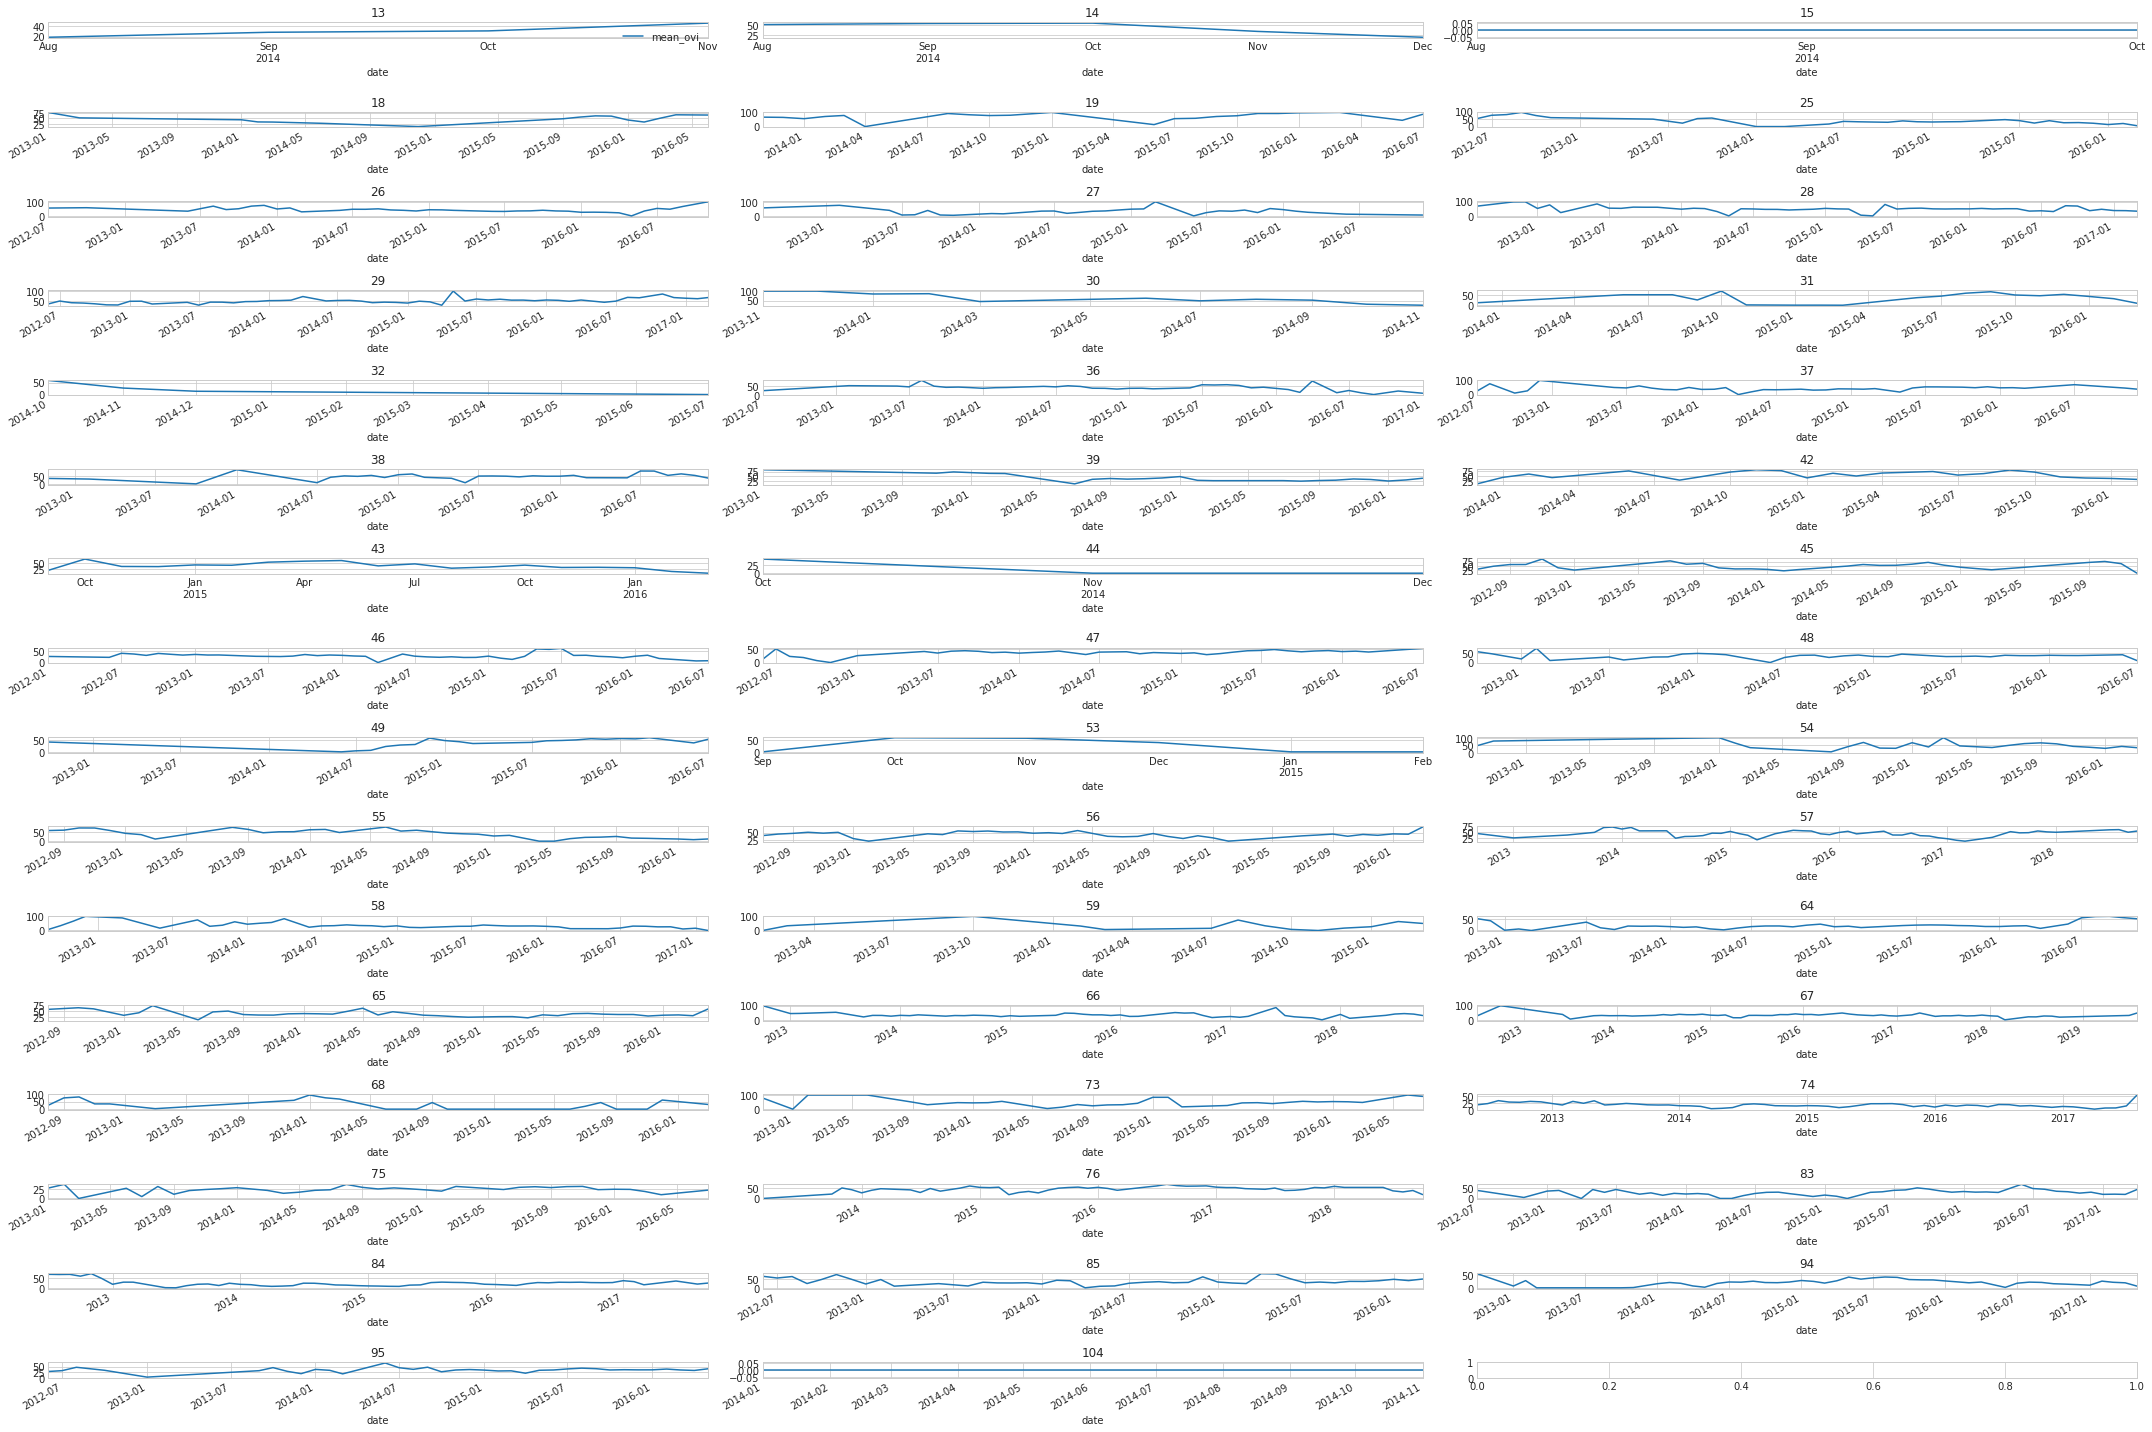

In [164]:
levels = aggregated_final.region_index.unique()

ncols = 3
nrows = int(np.ceil(len(levels)/ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(30, 20))
axes = axes.flatten()

for count, level in enumerate(levels):
    data_plot = aggregated_final.loc[aggregated_final['region_index'] == level]
    data_plot.plot(x='date', 
                   y='mean_ovi',
                   ax=axes[count]
                   )
    axes[count].set_title(level)
    if count > 0:
        axes[count].get_legend().remove()
    
plt.tight_layout()